In [ ]:
import numpy as np
import pickle
from sklearn.utils import shuffle, resample
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# === 1. Load Real Preprocessed Data ===
X_all_normalized = np.load('preprocessed_data/X_all_normalized.npy')
with open('preprocessed_data/sym_all.pkl', 'rb') as f:
    sym_all = pickle.load(f)

In [2]:
# === 2. Map Beat Symbols to Class Indices ===
unique_classes = sorted(set(sym_all))
label_to_index = {label: idx for idx, label in enumerate(unique_classes)}
num_classes = len(unique_classes)

# Create y_all as integer class labels
y_all = np.array([label_to_index[sym] for sym in sym_all])


In [3]:
# === 3. Resample Classes Between 10 and 8000 ===
class_counts = Counter(y_all)
X_resampled, y_resampled = [], []

for class_label, count in class_counts.items():
    if 10 <= count < 8000:
        indices = np.where(y_all == class_label)[0]
        X_class = X_all_normalized[indices]
        y_class = y_all[indices]

        X_upsampled, y_upsampled = resample(
            X_class, y_class,
            replace=True,
            n_samples=8000 - count,
            random_state=42
        )
        X_resampled.append(X_upsampled)
        y_resampled.append(y_upsampled)

# Combine real + resampled data
if X_resampled:
    X_resampled = np.vstack(X_resampled)
    y_resampled = np.concatenate(y_resampled)
    X_real_augmented = np.vstack([X_all_normalized, X_resampled])
    y_real_augmented = np.concatenate([y_all, y_resampled])
else:
    X_real_augmented = X_all_normalized
    y_real_augmented = y_all

In [4]:
# === 4. Load the GAN-Generated Class 'S' Samples ===
X_gen_S = np.load('generated_S_7998samples.npy')
s_index = label_to_index['S']
y_gen_S = np.full((X_gen_S.shape[0],), s_index)


In [5]:
# === 5. Combine All Data ===
X_combined = np.vstack([X_real_augmented, X_gen_S])
y_combined = np.concatenate([y_real_augmented, y_gen_S])

In [6]:
X_combined.shape

(178847, 2160)

In [7]:
# === 6. Shuffle ===
X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

# === 7. Reshape for Conv1D ===
X_combined = X_combined[..., np.newaxis]  # (samples, length, 1)

# === 8. One-Hot Encode Labels ===
y_combined_categorical = to_categorical(y_combined, num_classes=num_classes)

# === 9. Train-Validation Split ===
X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined_categorical, test_size=0.2, random_state=42)

In [8]:
X_train.shape

(143077, 2160, 1)

In [9]:
total_samples = X_combined.shape[0]
train_samples = X_train.shape[0]
test_samples = X_val.shape[0]

print(f"Total samples: {total_samples}")
print(f"Training samples: {train_samples} ({train_samples / total_samples:.2%})")
print(f"Testing samples: {test_samples} ({test_samples / total_samples:.2%})")

Total samples: 178847
Training samples: 143077 (80.00%)
Testing samples: 35770 (20.00%)


In [10]:
# Decode one-hot encoded labels back to class indices
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Count samples per class
train_class_counts = Counter(y_train_labels)
val_class_counts = Counter(y_val_labels)

# Map indices back to class labels (optional)
index_to_label = {v: k for k, v in label_to_index.items()}

# Print results
print("=== Training Set Class Distribution ===")
for idx, count in sorted(train_class_counts.items()):
    print(f"Class {index_to_label[idx]} (index {idx}): {count} samples")

print("\n=== Validation Set Class Distribution ===")
for idx, count in sorted(val_class_counts.items()):
    print(f"Class {index_to_label[idx]} (index {idx}): {count} samples")


=== Training Set Class Distribution ===
Class / (index 0): 6430 samples
Class A (index 1): 6384 samples
Class E (index 2): 6416 samples
Class F (index 3): 6430 samples
Class J (index 4): 6409 samples
Class L (index 5): 6484 samples
Class N (index 6): 59916 samples
Class R (index 7): 6374 samples
Class S (index 8): 6335 samples
Class V (index 9): 6399 samples
Class a (index 10): 6368 samples
Class e (index 11): 6370 samples
Class f (index 12): 6402 samples
Class j (index 13): 6360 samples

=== Validation Set Class Distribution ===
Class / (index 0): 1570 samples
Class A (index 1): 1616 samples
Class E (index 2): 1584 samples
Class F (index 3): 1570 samples
Class J (index 4): 1591 samples
Class L (index 5): 1568 samples
Class N (index 6): 14879 samples
Class R (index 7): 1626 samples
Class S (index 8): 1665 samples
Class V (index 9): 1601 samples
Class a (index 10): 1632 samples
Class e (index 11): 1630 samples
Class f (index 12): 1598 samples
Class j (index 13): 1640 samples


In [11]:
# === 10. Define CNN Model ===
model = Sequential([
    Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-10 21:46:31.407677: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-10 21:46:31.408359: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-10 21:46:31.408371: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-10 21:46:31.408543: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-10 21:46:31.408554: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fa

In [13]:
import time
# Start timer
start_time = time.time()

# === 11. Compile & Train ===
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=128
)

# End timer
end_time = time.time()

# Total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

Epoch 1/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 108s 96ms/step - accuracy: 0.7310 - loss: 0.9530 - val_accuracy: 0.9249 - val_loss: 0.3462
Epoch 2/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 105s 94ms/step - accuracy: 0.8376 - loss: 0.7964 - val_accuracy: 0.9296 - val_loss: 0.3704
Epoch 3/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.8382 - loss: 1.1532 - val_accuracy: 0.9110 - val_loss: 0.9776
Epoch 4/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 105s 94ms/step - accuracy: 0.8395 - loss: 2.7031 - val_accuracy: 0.9303 - val_loss: 1.6275
Epoch 5/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 106s 95ms/step - accuracy: 0.8522 - loss: 5.5857 - val_accuracy: 0.9385 - val_loss: 3.4064
Epoch 6/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 107s 96ms/step - accuracy: 0.8544 - loss: 12.5837 - val_accuracy: 0.9417 - val_loss: 7.6874
Epoch 7/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 105s 94ms/step - accuracy: 0.8661 - loss: 22.4754 - val_accuracy: 0.9523 - val_loss: 10.9195
Epoch 8/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 105s 94ms/step - accurac

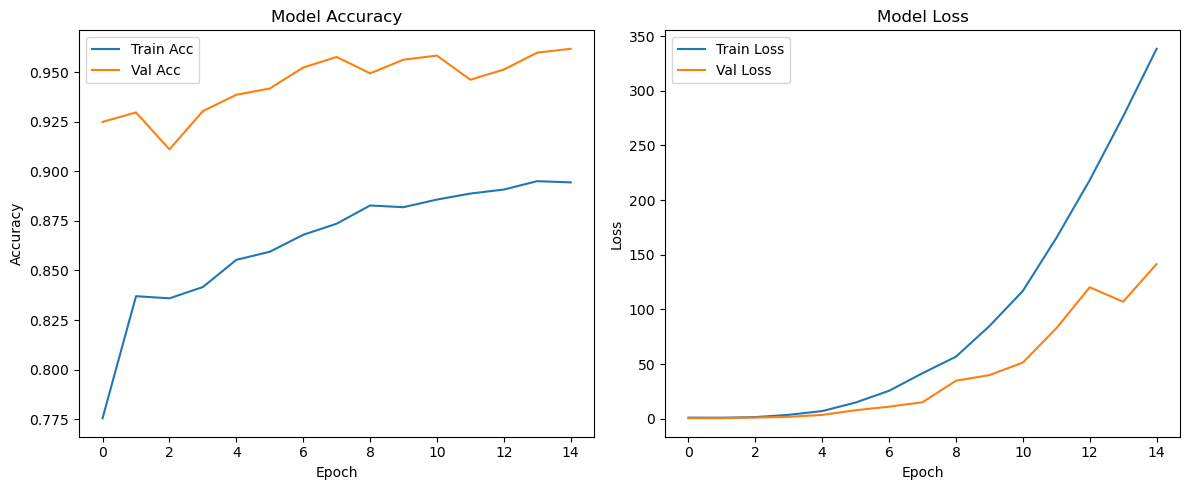

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predictions
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\n📊 Evaluation Metrics:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

1118/1118 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step

📊 Evaluation Metrics:
Accuracy  : 0.9617
Precision : 0.9666
Recall    : 0.9533
F1-score  : 0.9591



Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9659    0.9911    0.9783      1570
           1     0.8675    0.9239    0.8948      1616
           2     0.9981    1.0000    0.9991      1584
           3     0.9557    0.8382    0.8931      1570
           4     0.9831    0.9491    0.9658      1591
           5     0.9740    0.9560    0.9649      1568
           6     0.9549    0.9755    0.9651     14879
           7     0.9974    0.9311    0.9631      1626
           8     1.0000    1.0000    1.0000      1665
           9     0.9758    0.8557    0.9118      1601
          10     0.9461    1.0000    0.9723      1632
          11     0.9879    1.0000    0.9939      1630
          12     0.9572    0.9656    0.9614      1598
          13     0.9686    0.9598    0.9642      1640

    accuracy                         0.9617     35770
   macro avg     0.9666    0.9533    0.9591     35770
weighted avg     0.9623    0.9617    0.9614    

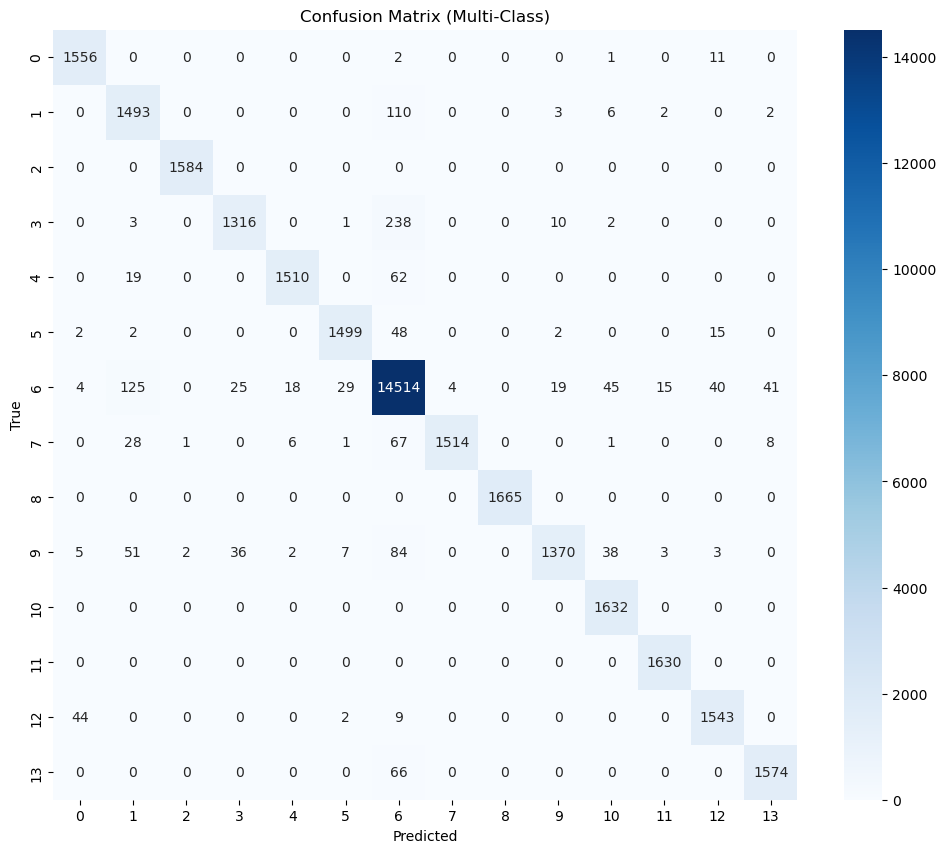

In [16]:
# Optional: Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
class_labels = list(range(14))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Multi-Class)')
plt.show()

/var/folders/vy/h0yt7lx97b5ct5kp84j7dk_40000gn/T/ipykernel_5535/3714886570.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=recall_per_class, palette='viridis')


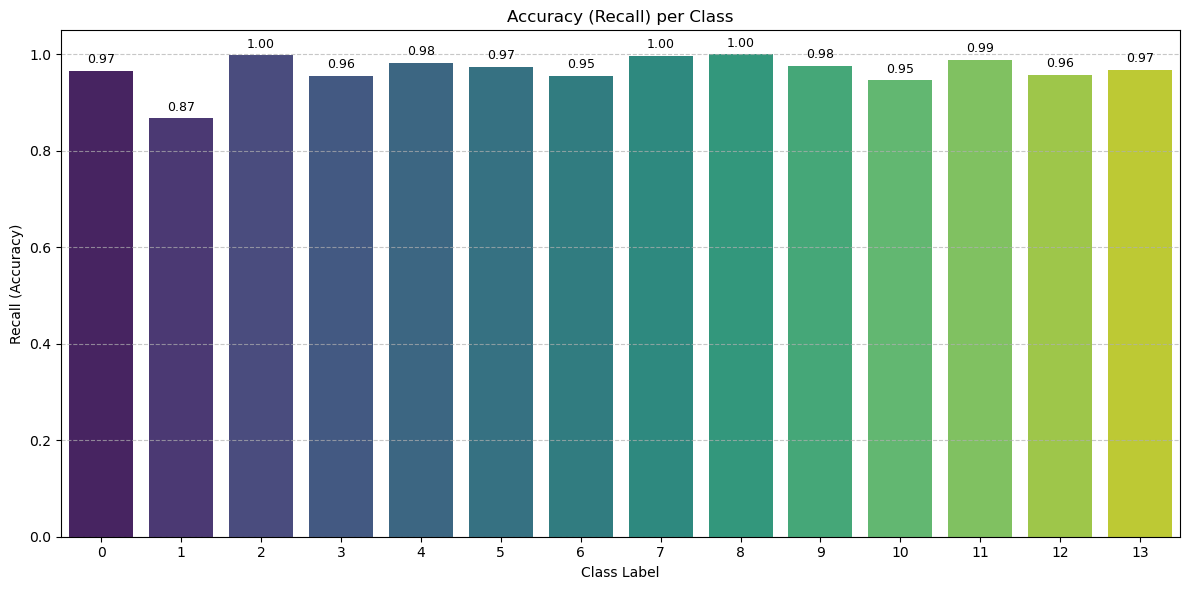

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class labels (0–13)
class_labels = list(range(14))

# Recall values (from your classification report)
recall_per_class = [
    0.9659,0.8675, 0.9981, 0.9557, 0.9831, 0.9740, 0.9549, 0.9974,1.0000, 0.9758, 0.9461, 0.9879, 0.9572, 0.9686
]

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=recall_per_class, palette='viridis')
plt.title('Accuracy (Recall) per Class')
plt.xlabel('Class Label')
plt.ylabel('Recall (Accuracy)')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display values on bars
for i, rec in enumerate(recall_per_class):
    plt.text(i, rec + 0.01, f"{rec:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
0.9659,0.8675, 0.9981, 0.9557, 0.9831, 0.9740, 0.9549, 0.9974,1.0000, 0.9758, 0.9461, 0.9879, 0.9572, 0.9686
